# Papermill

In [ ]:
model_parameter_name = None
dataset_parameter_name = None
my_task = None
uns_parameter_percentage = None
NA = False       # do not use augmentations for mnist and kandinsky
hide_parameter = None
hide_shapes_parameter = None  
hide_colors_parameter = None  
GPU_ID = None

In [2]:
assert model_parameter_name is not None, "model_parameter_name should not be None"
assert isinstance(model_parameter_name, str), "model_parameter_name should be a string"

assert uns_parameter_percentage is not None, "uns_parameter_percentage should not be None"
assert isinstance(uns_parameter_percentage, float), "uns_parameter_percentage should be a float"
assert 0.0 <= uns_parameter_percentage <= 1.0, "uns_parameter_percentage should be in the range [0.0, 1.0]"

assert dataset_parameter_name is not None, "dataset_parameter_name should not be None"
assert isinstance(dataset_parameter_name, str), "dataset_parameter_name should be a string"

#assert hide_parameter is not None, "hide_parameter should not be None"
#assert isinstance(hide_parameter, list), "hide_parameter should be a list"

assert GPU_ID is not None, "GPU_ID should not be None"
assert isinstance(GPU_ID, str), "GPU_ID should be a string"

print("Papermill model name is: " + model_parameter_name)
print("Papermill uns_parameter_percentage is: " + str(uns_parameter_percentage))
print("Papermill dataset name is: " + dataset_parameter_name)
print("Papermill hide is: " + str(hide_parameter))
print("Papermill hide_shapes is: " + str(hide_shapes_parameter))
print("Papermill hide_colors is: " + str(hide_colors_parameter))
print("Papermill dataset name is: " + dataset_parameter_name)
print("Papermill GPU_ID is: " + GPU_ID)

Papermill model name is: shieldedmnist
Papermill uns_parameter_percentage is: 1.0
Papermill dataset name is: shortmnist
Papermill hide is: None
Papermill hide_shapes is: None
Papermill hide_colors is: None
Papermill dataset name is: shortmnist
Papermill GPU_ID is: 1


# Imports

In [3]:
import sys
import os

os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID
sys.path.append(os.path.abspath(".."))

#if hide_colors_parameter is None or hide_shapes_parameter is None:
#    sys.exit("Bye!")

In [4]:
import torch
import random
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from utils.train import convert_to_categories, compute_coverage, compute_coverage_hard
from datasets.boia import BOIA
from datasets.boia_original import BDDDataset
from datasets.boia_original_embedded import FasterBDDOIADataset
from datasets.sddoia import SDDOIA
from datasets.minikandinsky import MiniKandinsky
from datasets.kandinsky import Kandinsky
from datasets.shortcutmnist import SHORTMNIST
from datasets.clipkandinsky import CLIPKandinsky
from datasets.clipshortcutmnist import CLIPSHORTMNIST
from datasets.clipboia import CLIPBOIA
#from datasets.clipSDDOIA import CLIPSDDOIA
from models.boiadpl import BoiaDPL
#from models.SDDOIAdpl import SDDOIADPL
from models.boialtn import BOIALTN
#from models.SDDOIAltn import SDDOIALTN
from models.boiann import BOIAnn
#from models.SDDOIAnn import SDDOIAnn
#from models.SDDOIAcbm import SDDOIACBM
from models.boiacbm import BoiaCBM
from models.mnistcbm import MnistCBM
from models.mnistdpl import MnistDPL
from models.mnistltn import MnistLTN
from models.mnistnn import MNISTnn
from models.mnistsl import MnistSL
from models.shieldedmnist import ShieldedMNIST
from models.proshieldedmnist import ProShieldedMNIST
from models.promnistsl import PROMnistSL
from models.promnistltn import PROMnistLTN
from models.promnistdpl import PROMnistDPL
from models.minikanddpl import MiniKandDPL
from models.prokanddpl import ProKandDPL
from models.prokandsl import ProKandSL
from models.prokandltn import ProKandLTN
from models.kanddpl import KandDPL
from models.kanddplsinglejoint import KandDPLSingleJoint
from models.kanddplsingledisj import KandDPLSingleDisj
from models.kandltnsinglejoint import KandLTNSingleJoint
from models.kandltnsingledisj import KandLTNSingleDisj
from models.kandslsinglejoint import KandSLSingleJoint
from models.kandslsingledisj import KandSLSingleDisj
from models.kandcbm import KandCBM
from models.kandltn import KANDltn
from models.kandnn import KANDnn
from models.kandsl import KandSL
from models.mnistltnrec import MnistLTNRec
from models.mnistdplrec import MnistDPLRec
from models.mnistslrec import MnistSLRec
from sklearn.metrics import confusion_matrix
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO

%matplotlib inline

In [5]:
from shortcut_mitigation.kandinsky.protonet_kand_modules.data_modules.proto_data_creation import get_random_classes
from shortcut_mitigation.mnist.protonet_mnist_add_modules.data_modules.proto_data_creation import (
    choose_initial_prototypes, 
    get_augmented_support_query_set
)

In [6]:
def my_gpu_info():
    print("Torch version: ", torch.__version__)  

    if torch.cuda.is_available():
        print("CUDA version: ", torch.version.cuda)
        num_gpus = torch.cuda.device_count()
        print(f"Number of GPUs available: {num_gpus}")
        
        for i in range(num_gpus):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
            print(f"  Memory Cached: {torch.cuda.memory_reserved(i)} bytes")
    else:
        print("CUDA is not available on this system.")

my_gpu_info()

Torch version:  1.13.0+cu117
CUDA version:  11.7
Number of GPUs available: 1
Device 0: NVIDIA TITAN Xp
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


Class containing all the metrics which we are evaluating

In [7]:
class Metrics:
    def __init__(
        self,
        concept_accuracy,
        label_accuracy,
        concept_f1_macro,
        concept_f1_micro,
        concept_f1_weighted,
        label_f1_macro,
        label_f1_micro,
        label_f1_weighted,
        collapse,
        collapse_hard,
        avg_nll,
    ):
        self.concept_accuracy = concept_accuracy
        self.label_accuracy = label_accuracy
        self.concept_f1_macro = concept_f1_macro
        self.concept_f1_micro = concept_f1_micro
        self.concept_f1_weighted = concept_f1_weighted
        self.label_f1_macro = label_f1_macro
        self.label_f1_micro = label_f1_micro
        self.label_f1_weighted = label_f1_weighted
        self.collapse = collapse
        self.collapse_hard = collapse_hard
        self.avg_nll = avg_nll


class BOIAMetrics(Metrics):
    def __init__(
        self,
        concept_accuracy,
        label_accuracy,
        concept_f1_macro,
        concept_f1_micro,
        concept_f1_weighted,
        label_f1_macro,
        label_f1_micro,
        label_f1_weighted,
        collapse,
        collapse_hard,
        collapse_forward,
        collapse_stop,
        collapse_left,
        collapse_right,
        collapse_hard_forward,
        collapse_hard_stop,
        collapse_hard_left,
        collapse_hard_right,
        mean_collapse,
        mean_hard_collapse,
        avg_nll,
    ):
        super(BOIAMetrics, self).__init__(
            concept_accuracy,
            label_accuracy,
            concept_f1_macro,
            concept_f1_micro,
            concept_f1_weighted,
            label_f1_macro,
            label_f1_micro,
            label_f1_weighted,
            collapse,
            collapse_hard,
            avg_nll,
        )
        self.collapse_forward = collapse_forward
        self.collapse_stop = collapse_stop
        self.collapse_left = collapse_left
        self.collapse_right = collapse_right
        self.collapse_hard_forward = collapse_hard_forward
        self.collapse_hard_stop = collapse_hard_stop
        self.collapse_hard_left = collapse_hard_left
        self.collapse_hard_right = collapse_hard_right
        self.mean_collapse = mean_collapse
        self.mean_hard_collapse = mean_hard_collapse


class KandMetrics(Metrics):
    def __init__(
        self,
        concept_accuracy,
        label_accuracy,
        concept_f1_macro,
        concept_f1_micro,
        concept_f1_weighted,
        label_f1_macro,
        label_f1_micro,
        label_f1_weighted,
        collapse,
        collapse_hard,
        avg_nll,
        collapse_shapes,
        collapse_hard_shapes,
        collapse_color,
        collapse_hard_color,
        mean_collapse,
        mean_collapse_hard,
    ):
        super(KandMetrics, self).__init__(
            concept_accuracy,
            label_accuracy,
            concept_f1_macro,
            concept_f1_micro,
            concept_f1_weighted,
            label_f1_macro,
            label_f1_micro,
            label_f1_weighted,
            collapse,
            collapse_hard,
            avg_nll,
        )
        self.collapse_shapes = collapse_shapes
        self.collapse_hard_shapes = collapse_hard_shapes
        self.collapse_color = collapse_color
        self.collapse_hard_color = collapse_hard_color
        self.mean_collapse = mean_collapse
        self.mean_collapse_hard = mean_collapse_hard

Function used to compute the concept collapse

In [8]:
def compute_concept_collapse(true_concepts, predicted_concepts, multilabel=False):
    if multilabel:
        true_concepts = convert_to_categories(true_concepts.astype(int))
        predicted_concepts = convert_to_categories(predicted_concepts.astype(int))

    return 1 - compute_coverage(confusion_matrix(true_concepts, predicted_concepts))


def compute_hard_concept_collapse(true_concepts, predicted_concepts, multilabel=False):
    if multilabel:
        true_concepts = convert_to_categories(true_concepts.astype(int))
        predicted_concepts = convert_to_categories(predicted_concepts.astype(int))

    return 1 - compute_coverage_hard(
        confusion_matrix(true_concepts, predicted_concepts)
    )

Function used to plot confusion matrix

In [9]:
def plot_confusion_matrix(
    true_labels,
    predicted_labels,
    classes,
    normalize=False,
    title=None,
    is_boia=False,
    cmap=plt.cm.Oranges,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = np.zeros((len(classes), len(classes)))
    for i in range(len(true_labels)):
        cm[true_labels[i], predicted_labels[i]] += 1

    if normalize:
        cm = cm.astype("float")
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        cm = np.where(row_sums == 0, 0, cm / row_sums)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.8)
    red_yellow_palette = sns.color_palette("OrRd", as_cmap=True)
    heatmap = sns.heatmap(
        cm,
        annot=False,
        fmt=".2f" if normalize else "d",
        cmap=red_yellow_palette,
        cbar=True,
    )

    if title:
        plt.savefig(title, format="pdf")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [10]:

# ! new method to express concepts in the confusion matrix for KAND
def encode_labels_KAND(tensor):
    """
    Encodes (shape, color) combinations into a single scalar index.
    Args:
        tensor: Input tensor with shape (N, 6), where the first 3 columns are shapes
                and the last 3 columns are colors.
    Returns:
        Encoded labels as a 1D array.
    """
    shape_indices = tensor[:, :3]  # First 3 columns represent shapes
    color_indices = tensor[:, 3:]  # Last 3 columns represent colors

    # Combine each shape-color pair into a single label index
    encoded_labels = []
    for i in range(tensor.shape[0]):  # Loop over each sample
        for shape, color in zip(shape_indices[i], color_indices[i]):
            # Map (shape, color) -> unique index
            label = 3 * shape.item() + color.item()  # Shape: {0,1,2}, Color: {0,1,2}
            encoded_labels.append(label)
    return np.array(encoded_labels)

In [11]:
def plot_confusion_matrix_KAND(true_concepts, predicted_concepts, classes, class_labels, normalize=True,
                               title=None, cmap=plt.cm.Oranges):
    """
    Plots a confusion matrix with custom class labels.

    Args:
        true_concepts: Array of true concept indices.
        predicted_concepts: Array of predicted concept indices.
        classes: List (or array) of unique classes.
        class_labels: List of custom class labels corresponding to the classes.
        normalize: Whether to normalize the values.
        title: Optional title for the confusion matrix. If provided, the figure is saved as a PDF.
        cmap: Colormap to use for the heatmap.
    """
    # Create the confusion matrix
    cm = np.zeros((len(classes), len(classes)))
    for i in range(len(true_concepts)):
        cm[true_concepts[i], predicted_concepts[i]] += 1

    # Normalize if needed
    if normalize:
        cm = cm.astype("float")
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        cm = np.where(row_sums == 0, 0, cm / row_sums)
    
    # Ensure that only an extra empty row/column is removed while keeping all valid labels
    if cm.shape[0] > len(class_labels):  # If there's an extra blank row/column
        if np.all(cm[-1, :] == 0) and np.all(cm[:, -1] == 0):  # Check if last row and column are empty
            cm = cm[:-1, :-1]  # Remove the last row and column

    # Plotting setup
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")
    heatmap = sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap=cmap,
        cbar=True,
        xticklabels=class_labels[:cm.shape[1]],  # Keep all valid labels
        yticklabels=class_labels[:cm.shape[0]],
        linewidths=0.5,
        linecolor='lightgrey'
    )
    # Rotate x-axis labels to 45° for better readability
    heatmap.set_xticklabels(class_labels[:cm.shape[1]], rotation=45, fontsize=10)
    heatmap.set_yticklabels(class_labels[:cm.shape[0]], rotation=0, fontsize=10)
    
    if title:
        plt.title(title, fontsize=12)
        # Save the figure with tight bounding box to prevent label cutoff
        plt.savefig(title, format="pdf", bbox_inches='tight')

    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.tight_layout()
    # Increase bottom margin to ensure x labels are visible
    plt.subplots_adjust(bottom=0.2)
    plt.show()


Function used to compute the metrics

In [12]:
def compute_metrics(
    true_labels,
    predicted_labels,
    true_concepts,
    predicted_concepts,
    avg_nll,
    dataset_name,
    model_name,
    seed,
    save_name
):

    # multilabel or not
    multilabel_concept = False
    multilabel_label = False

    if dataset_name in ["boia", "boia_original", "boia_original_embedded", "sddoia", "clipboia", "clipSDDOIA"]:
        multilabel_concept = True
        multilabel_label = True

    if dataset_name in ["kandinsky", "minikandinsky", "clipkandinsky"]:
        collapse_true_concepts_list = torch.tensor(true_concepts)
        collapse_true_concepts_list = torch.split(collapse_true_concepts_list, 3, dim=1)
        collapse_pred_concepts_list = torch.tensor(predicted_concepts)
        collapse_pred_concepts_list = torch.split(collapse_pred_concepts_list, 3, dim=1)

        collapse_true_concepts_1 = collapse_true_concepts_list[0].flatten()
        collapse_true_concepts_2 = collapse_true_concepts_list[1].flatten()
        collapse_true_concepts = torch.stack(
            (collapse_true_concepts_1, collapse_true_concepts_2), dim=1
        )
        # to int
        collapse_true_concepts = (
            collapse_true_concepts[:, 0] * 3 + collapse_true_concepts[:, 1]
        )
        collapse_true_concepts = collapse_true_concepts.detach().numpy()

        collapse_pred_concepts_1 = collapse_pred_concepts_list[0].flatten()
        collapse_pred_concepts_2 = collapse_pred_concepts_list[1].flatten()
        collapse_pred_concepts = torch.stack(
            (collapse_pred_concepts_1, collapse_pred_concepts_2), dim=1
        )
        # to int
        collapse_pred_concepts = (
            collapse_pred_concepts[:, 0] * 3 + collapse_pred_concepts[:, 1]
        )
        collapse_pred_concepts = collapse_pred_concepts.detach().numpy()

        # total collapse
        collapse = compute_concept_collapse(
            collapse_true_concepts, collapse_pred_concepts, multilabel_concept
        )

        collapse_hard = compute_hard_concept_collapse(
            collapse_true_concepts, collapse_pred_concepts, multilabel_concept
        )

    else:
        # total collapse
        collapse = compute_concept_collapse(
            true_concepts, predicted_concepts, multilabel_concept
        )

        collapse_hard = compute_hard_concept_collapse(
            true_concepts, predicted_concepts, multilabel_concept
        )

    if dataset_name in ["boia", "boia_original", "boia_original_embedded", "sddoia", "clipboia", "clipSDDOIA"]:
        # additional metrics for boia and sddoia
        collapse_forward, collapse_hard_forward = compute_concept_collapse(
            true_concepts[:, :3], predicted_concepts[:, :3], True
        ), compute_hard_concept_collapse(
            true_concepts[:, :3], predicted_concepts[:, :3], True
        )
        collapse_stop, collapse_hard_stop = compute_concept_collapse(
            true_concepts[:, 3:9], predicted_concepts[:, 3:9], True
        ), compute_hard_concept_collapse(
            true_concepts[:, 3:9], predicted_concepts[:, 3:9], True
        )
        collapse_left, collapse_hard_left = compute_concept_collapse(
            true_concepts[:, 9:15], predicted_concepts[:, 9:15], True
        ), compute_hard_concept_collapse(
            true_concepts[:, 9:15], predicted_concepts[:, 9:15], True
        )
        collapse_right, collapse_hard_right = compute_concept_collapse(
            true_concepts[:, 15:21], predicted_concepts[:, 15:21], True
        ), compute_hard_concept_collapse(
            true_concepts[:, 15:21], predicted_concepts[:, 15:21], True
        )

        mean_collapse, mean_hard_collapse = np.mean(
            [collapse_forward, collapse_stop, collapse_left, collapse_right]
        ), np.mean(
            [
                collapse_hard_forward,
                collapse_hard_stop,
                collapse_hard_left,
                collapse_hard_right,
            ]
        )

    elif dataset_name in ["minikandinsky", "kandinsky", "clipkandinsky"]:
        # additional metrics for boia and sddoia
        collapse_color, collapse_hard_color = compute_concept_collapse(
            true_concepts[:, 3:6].reshape(-1),
            predicted_concepts[:, 3:6].reshape(-1),
            False,
        ), compute_hard_concept_collapse(
            true_concepts[:, 3:6].reshape(-1),
            predicted_concepts[:, 3:6].reshape(-1),
            False,
        )
        collapse_shapes, collapse_hard_shapes = compute_concept_collapse(
            true_concepts[:, :3].reshape(-1),
            predicted_concepts[:, :3].reshape(-1),
            False,
        ), compute_hard_concept_collapse(
            true_concepts[:, :3].reshape(-1),
            predicted_concepts[:, :3].reshape(-1),
            False,
        )

        mean_collapse, mean_collapse_hard = np.mean(
            [collapse_color, collapse_shapes]
        ), np.mean([collapse_hard_color, collapse_hard_shapes])

    if multilabel_concept:
        concept_accuracy, concept_f1_macro, concept_f1_micro, concept_f1_weighted = (
            0,
            0,
            0,
            0,
        )

        for i in range(true_concepts.shape[1]):
            print(true_concepts[i])
            print(predicted_concepts[i])
            #raise RuntimeError("Multilabel concept not implemented")
            concept_accuracy += accuracy_score(true_concepts[i], predicted_concepts[i])
            concept_f1_macro += f1_score(
                true_concepts[i], predicted_concepts[i], average="macro"
            )
            concept_f1_micro += f1_score(
                true_concepts[i], predicted_concepts[i], average="micro"
            )
            concept_f1_weighted += f1_score(
                true_concepts[i], predicted_concepts[i], average="weighted"
            )

        print(true_concepts.shape[1])
        concept_accuracy = concept_accuracy / true_concepts.shape[1]
        concept_f1_macro = concept_f1_macro / true_concepts.shape[1]
        concept_f1_micro = concept_f1_micro / true_concepts.shape[1]
        concept_f1_weighted = concept_f1_weighted / true_concepts.shape[1]

        label_accuracy, label_f1_macro, label_f1_micro, label_f1_weighted = 0, 0, 0, 0
    elif dataset_name in ["kandinsky", "minikandinsky", "clipkandinsky"]:
        concept_accuracy_color = accuracy_score(
            true_concepts[:, 3:6].reshape(-1), predicted_concepts[:, 3:6].reshape(-1)
        )
        concept_f1_macro_color = f1_score(
            true_concepts[:, 3:6].reshape(-1),
            predicted_concepts[:, 3:6].reshape(-1),
            average="macro",
        )
        concept_f1_micro_color = f1_score(
            true_concepts[:, 3:6].reshape(-1),
            predicted_concepts[:, 3:6].reshape(-1),
            average="micro",
        )
        concept_f1_weighted_color = f1_score(
            true_concepts[:, 3:6].reshape(-1),
            predicted_concepts[:, 3:6].reshape(-1),
            average="weighted",
        )

        concept_accuracy_shape = accuracy_score(
            true_concepts[:, :3].reshape(-1), predicted_concepts[:, :3].reshape(-1)
        )
        concept_f1_macro_shape = f1_score(
            true_concepts[:, :3].reshape(-1),
            predicted_concepts[:, :3].reshape(-1),
            average="macro",
        )
        concept_f1_micro_shape = f1_score(
            true_concepts[:, :3].reshape(-1),
            predicted_concepts[:, :3].reshape(-1),
            average="micro",
        )
        concept_f1_weighted_shape = f1_score(
            true_concepts[:, :3].reshape(-1),
            predicted_concepts[:, :3].reshape(-1),
            average="weighted",
        )

        concept_accuracy = np.mean([concept_accuracy_color, concept_accuracy_shape])
        concept_f1_macro = np.mean([concept_f1_macro_color, concept_f1_macro_shape])
        concept_f1_micro = np.mean([concept_f1_micro_color, concept_f1_micro_shape])
        concept_f1_weighted = np.mean(
            [concept_f1_weighted_color, concept_f1_weighted_shape]
        )

    else:
        concept_accuracy = accuracy_score(true_concepts, predicted_concepts)
        concept_f1_macro = f1_score(true_concepts, predicted_concepts, average="macro")
        concept_f1_micro = f1_score(true_concepts, predicted_concepts, average="micro")
        concept_f1_weighted = f1_score(
            true_concepts, predicted_concepts, average="weighted"
        )

    if multilabel_label:
        for i in range(true_labels.shape[1]):
            label_accuracy += accuracy_score(true_labels[i], predicted_labels[i])
            label_f1_macro += f1_score(
                true_labels[i], predicted_labels[i], average="macro"
            )
            label_f1_micro += f1_score(
                true_labels[i], predicted_labels[i], average="micro"
            )
            label_f1_weighted += f1_score(
                true_labels[i], predicted_labels[i], average="weighted"
            )

        label_accuracy = label_accuracy / true_labels.shape[1]
        label_f1_macro = label_f1_macro / true_labels.shape[1]
        label_f1_micro = label_f1_micro / true_labels.shape[1]
        label_f1_weighted = label_f1_weighted / true_labels.shape[1]
    else:
        label_accuracy = accuracy_score(true_labels, predicted_labels)
        label_f1_macro = f1_score(true_labels, predicted_labels, average="macro")
        label_f1_micro = f1_score(true_labels, predicted_labels, average="micro")
        label_f1_weighted = f1_score(true_labels, predicted_labels, average="weighted")

    if dataset_name in ["boia", "boia_original", "boia_original_embedded", "sddoia", "clipboia", "clipSDDOIA"]:
        metrics = BOIAMetrics(
            concept_accuracy=concept_accuracy,
            label_accuracy=label_accuracy,
            concept_f1_macro=concept_f1_macro,
            concept_f1_micro=concept_f1_micro,
            concept_f1_weighted=concept_f1_weighted,
            label_f1_macro=label_f1_macro,
            label_f1_micro=label_f1_micro,
            label_f1_weighted=label_f1_weighted,
            collapse=collapse,
            collapse_hard=collapse_hard,
            collapse_forward=collapse_forward,
            collapse_stop=collapse_stop,
            collapse_right=collapse_right,
            collapse_left=collapse_left,
            collapse_hard_forward=collapse_hard_forward,
            collapse_hard_stop=collapse_hard_stop,
            collapse_hard_right=collapse_hard_right,
            collapse_hard_left=collapse_hard_left,
            mean_collapse=mean_collapse,
            mean_hard_collapse=mean_hard_collapse,
            avg_nll=avg_nll,
        )
    elif dataset_name in ["minikandinsky", "kandinsky", "clipkandinsky"]:
        metrics = KandMetrics(
            concept_accuracy=concept_accuracy,
            label_accuracy=label_accuracy,
            concept_f1_macro=concept_f1_macro,
            concept_f1_micro=concept_f1_micro,
            concept_f1_weighted=concept_f1_weighted,
            label_f1_macro=label_f1_macro,
            label_f1_micro=label_f1_micro,
            label_f1_weighted=label_f1_weighted,
            collapse=collapse,
            collapse_hard=collapse_hard,
            avg_nll=avg_nll,
            collapse_shapes=collapse_shapes,
            collapse_color=collapse_color,
            collapse_hard_shapes=collapse_hard_shapes,
            mean_collapse_hard=mean_collapse_hard,
            mean_collapse=mean_collapse,
            collapse_hard_color=collapse_hard_color,
        )
    else:
        metrics = Metrics(
            concept_accuracy=concept_accuracy,
            label_accuracy=label_accuracy,
            concept_f1_macro=concept_f1_macro,
            concept_f1_micro=concept_f1_micro,
            concept_f1_weighted=concept_f1_weighted,
            label_f1_macro=label_f1_macro,
            label_f1_micro=label_f1_micro,
            label_f1_weighted=label_f1_weighted,
            collapse=collapse,
            collapse_hard=collapse_hard,
            avg_nll=avg_nll,
        )

    if dataset_name in ["shortmnist"]:
        plot_confusion_matrix(
            true_concepts,
            predicted_concepts,
            classes=[i for i in range(10)],
            normalize=True,
            #title=f"{model_name}_{dataset_name}_{seed}.pdf",
            title= save_name + f"_{seed}.pdf",
            is_boia=True,
        )
    elif dataset_name in ["boia", "boia_original", "boia_original_embedded", "sddoia"]:

        plot_confusion_matrix(
            convert_to_categories(true_concepts[:, :3].astype(int)),
            convert_to_categories(predicted_concepts[:, :3].astype(int)),
            ["" for i in range(2**3)],
            True,
            save_name + f"{model_name}_{dataset_name}_{seed}_forward.pdf"
            #f"{model_name}_{dataset_name}_{seed}_forward.pdf",
        )
        plot_confusion_matrix(
            convert_to_categories(true_concepts[:, 3:9].astype(int)),
            convert_to_categories(predicted_concepts[:, 3:9].astype(int)),
            ["" for i in range(2**6)],
            True,
            save_name + f"{model_name}_{dataset_name}_{seed}_stop.pdf"
            #f"{model_name}_{dataset_name}_{seed}_stop.pdf",
        )
        plot_confusion_matrix(
            convert_to_categories(true_concepts[:, 9:15].astype(int)),
            convert_to_categories(predicted_concepts[:, 9:15].astype(int)),
            ["" for i in range(2**6)],
            True,
            save_name + f"{model_name}_{dataset_name}_{seed}_left.pdf"
            #f"{model_name}_{dataset_name}_{seed}_left.pdf",
        )
        plot_confusion_matrix(
            convert_to_categories(true_concepts[:, 15:21].astype(int)),
            convert_to_categories(predicted_concepts[:, 15:21].astype(int)),
            ["" for i in range(2**6)],
            True,
            save_name + f"{model_name}_{dataset_name}_{seed}_right.pdf"
            #f"{model_name}_{dataset_name}_{seed}_right.pdf",
        )
    elif dataset_name in ["kandinsky", "minikandinsky"]:
        shapes = ['Square', 'Circle', 'Triangle']
        colors = ['Red', 'Yellow', 'Blue']
        class_labels = [f"({shape}, {color})" for shape in shapes for color in colors]

        plot_confusion_matrix_KAND(
            true_concepts=encode_labels_KAND(true_concepts),
            predicted_concepts=encode_labels_KAND(predicted_concepts),
            classes=[i for i in range(10)],
            class_labels=class_labels,
            normalize=True,
            title=save_name + f"{model_name}_{dataset_name}_{seed}.pdf",
        )
    return metrics

Load the right dataset and the right model

In [13]:
def get_dataset(datasetname, args):
    if datasetname.lower() == "boia":
        return BOIA(args)
    if datasetname.lower() == "boia_original":
        return BDDDataset(args)
    if datasetname.lower() == "boia_original_embedded":
        return FasterBDDOIADataset(args)
    if datasetname.lower() == "sddoia":
        return SDDOIA(args)
    if datasetname.lower() == "minikandinsky":
        return MiniKandinsky(args)
    if datasetname.lower() == "kandinsky":
        return Kandinsky(args)
    if datasetname.lower() == "shortmnist":
        return SHORTMNIST(args)
    if datasetname.lower() == "clipkandinsky":
        return CLIPKandinsky(args)
    if datasetname.lower() == "clipshortmnist":
        return CLIPSHORTMNIST(args)
    if datasetname.lower() == "clipboia":
        return CLIPBOIA(args)
    if datasetname.lower() == "clipSDDOIA":
        return CLIPSDDOIA(args)

    raise NotImplementedError(f"Dataset {datasetname} missing")

In [14]:
def get_model(modelname, encoder, args, decoder=None):
    if modelname.lower() == "boiadpl":
        return BoiaDPL(encoder=encoder, args=args)
    if modelname.lower() == "SDDOIAdpl":
        return SDDOIADPL(encoder=encoder, args=args)
    if modelname.lower() == "boialtn":
        return BOIALTN(encoder=encoder, args=args)
    if modelname.lower() == "SDDOIAltn":
        return SDDOIALTN(encoder=encoder, args=args)
    if modelname.lower() == "boiann":
        return BOIAnn(encoder=encoder, args=args)
    if modelname.lower() == "SDDOIAnn":
        return SDDOIAnn(encoder=encoder, args=args)
    if modelname.lower() == "boiacbm":
        return BoiaCBM(encoder=encoder, args=args)
    if modelname.lower() == "SDDOIAcbm":
        return SDDOIACBM(encoder=encoder, args=args)
    if modelname.lower() == "minikanddpl":
        return MiniKandDPL(encoder=encoder, args=args)
    if modelname.lower() == "kandltn":
        return KANDltn(encoder=encoder, args=args)
    if modelname.lower() == "kandnn":
        return KANDnn(encoder=encoder, args=args)
    if modelname.lower() == "kanddpl":
        return KandDPL(encoder=encoder, args=args)
    if modelname.lower() == "prokanddpl":
        return ProKandDPL(encoder=encoder, args=args)
    if modelname.lower() == "prokandsl":
        return ProKandSL(encoder=encoder, args=args)
    if modelname.lower() == "prokandltn":
        return ProKandLTN(encoder=encoder, args=args)
    if modelname.lower() == "kanddplsinglejoint":
        return KandDPLSingleJoint(encoder=encoder, args=args)
    if modelname.lower() == "kanddplsingledisj":
        return KandDPLSingleDisj(encoder=encoder, args=args)
    if modelname.lower() == "kandslsinglejoint":
        return KandSLSingleJoint(encoder=encoder, args=args)
    if modelname.lower() == "kandslsingledisj":
        return KandSLSingleDisj(encoder=encoder, args=args)
    if modelname.lower() == "kandltnsinglejoint":
        return KandLTNSingleJoint(encoder=encoder, args=args)
    if modelname.lower() == "kandltnsingledisj":
        return KandLTNSingleDisj(encoder=encoder, args=args)
    if modelname.lower() == "kandcbm":
        return KandCBM(encoder=encoder, args=args)
    if modelname.lower() == 'kandsl':
        return KandSL(encoder=encoder, args=args)
    if modelname.lower() == 'promnistsl':
        return PROMnistSL(encoder=encoder, args=args)
    if modelname.lower() == 'promnistltn':
        return PROMnistLTN(encoder=encoder, args=args)
    if modelname.lower() == "promnistdpl":
        return PROMnistDPL(encoder=encoder, args=args)
    if modelname.lower() == "mnistdpl":
        return MnistDPL(encoder=encoder, args=args)
    if modelname.lower() == "mnistltn":
        return MnistLTN(encoder=encoder, args=args)
    if modelname.lower() == "mnistsl":
        return MnistSL(encoder=encoder, args=args)
    if modelname.lower() == "mnistnn":
        return MNISTnn(encoder=encoder, args=args)
    if modelname.lower() == "mnistcbm":
        return MnistCBM(encoder=encoder, args=args)
    if modelname.lower() == 'mnistltnrec':
        return MnistLTNRec(encoder=encoder, args=args, decoder=decoder)
    if modelname.lower() == 'mnistdplrec':
        return MnistDPLRec(encoder=encoder, args=args, decoder=decoder)
    if modelname.lower() == "mnistslrec":
        return MnistSLRec(encoder=encoder, args=args, decoder=decoder)
    if modelname.lower() == "shieldedmnist":
        return ShieldedMNIST(encoder=encoder, args=args)
    if modelname.lower() == "proshieldedmnist":
        return ProShieldedMNIST(encoder=encoder, args=args)

    raise NotImplementedError(f"Model {modelname} missing")

# Parameters

In [15]:
args = Namespace(
    backbone="conceptizer",  
    preprocess=0,
    finetuning=0,
    batch_size=8,
    n_epochs=10,
    validate=0,
    dataset=dataset_parameter_name,
    lr=0.001,
    exp_decay=0.99,
    warmup_steps=1,
    wandb=None,
    task=my_task,
    boia_model="ce",
    model=model_parameter_name,           
    c_sup=0.0,
    which_c=[],
    joint=False,
    boia_ood_knowledge=True,
    debug=False,
    device='cuda',
    GPU_ID=GPU_ID,
    hide=hide_parameter,
    hide_shapes=hide_shapes_parameter,
    hide_colors=hide_colors_parameter,

    # & prototypical network
    n_support=75,                     # 75
    prototypes=False,                  # ^ change this to False to disable prototypical network
    prototypical_loss_weight=1.0,
    embedding_dim=64,
    mlp=True,
)

# get dataset
dataset = get_dataset(args.dataset, args)
# get model
encoder, decoder = dataset.get_backbone()
model = get_model(modelname=args.model, encoder=encoder, args=args, decoder=decoder)

model.device = args.device

model.to(model.device)
if hasattr(model, "encoder"):
    model.encoder.to(model.device)
elif hasattr(model, "net"):
    model.net.to(model.device)

Custom ordering for shield: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38


# Folder

In [ ]:
seeds = [0, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

# choose the dataset subfolder
save_folder = None
if args.dataset == 'shortmnist':                                            
    save_folder = "mnadd-even-odd"
if args.dataset == 'kandinsky':                                             
    save_folder = "kandinsky"      
if args.dataset in ['boia', 'boia_original', 'boia_original_embedded']:     
    save_folder = "bddoia"

# choose the model name
save_model_name = None
if "ltn" in args.model:     save_model_name = 'ltn' 
if "dpl" in args.model:     save_model_name = 'dpl'
if "sl" in args.model:      save_model_name = 'sl' 
if "shield" in args.model:  save_model_name = 'ccn+'

save_path = os.path.join("..", "shortcut_mitigation", 
    "outputs++",
    save_folder, 
    "baseline",
    save_model_name,
    #f"episodic-proto-net-pipeline-{uns_parameter_percentage}-HIDE-[]",
    #f"pretrained-{uns_parameter_percentage}+c"
    "pretrained-1.0+c"
)

model_path = os.path.join(save_path, save_model_name)
extractor_path = os.path.join(save_path, "best")
save_name = model_path

Loop through the dataset and retrive concepts and labels

In [17]:
def get_concepts_and_labels_boia(out_labels, out_concepts):
    batch_size = out_labels.size(0)

    predicted_labels, predicted_concepts = [], []

    for idx_batch in range(batch_size):
        prob_labels = torch.split(out_labels[idx_batch], 2)
        prob_concepts = torch.split(out_concepts[idx_batch], 2)

        tmp_lab, tmp_conc = [], []

        for l_lab in prob_labels:
            tmp_lab.append(torch.argmax(l_lab, dim=0))
        for l_conc in prob_concepts:
            tmp_conc.append(torch.argmax(l_conc, dim=0))

        predicted_labels.append(torch.tensor([tmp_lab]))
        predicted_concepts.append(torch.tensor([tmp_conc]))

    predicted_labels = torch.concatenate(predicted_labels, dim=0)
    predicted_concepts = torch.concatenate(predicted_concepts, dim=0)

    return predicted_labels, predicted_concepts

In [18]:
def get_concepts_and_labels_mnist(
    out_labels, out_concepts, true_concepts, is_ood=False
):

    # filtering out the extended support
    if not is_ood:
        for i in range(19):
            if i in [6, 10, 12]:
                continue
            out_labels[:, i] = 0

    predicted_labels = torch.argmax(out_labels, dim=-1)
    predicted_concepts = torch.argmax(out_concepts, dim=-1)

    predicted_concepts = predicted_concepts.view(predicted_concepts.numel())
    refactored_true_concepts = true_concepts.view(true_concepts.numel())

    # print("Predicted Labels: ", predicted_labels)
    return predicted_labels, predicted_concepts, refactored_true_concepts

In [19]:
def get_concepts_and_labels_kand(out_labels, out_concepts, true_concepts):

    # take the prediction
    predicted_labels = torch.argmax(out_labels, dim=1)

    # stack colors and shapes on top of each other
    refactored_true_concepts = torch.split(true_concepts, 1, dim=1)
    refactored_true_concepts = torch.concatenate(
        refactored_true_concepts, dim=0
    ).squeeze(1)

    # take the prediction
    predicted_concepts_list = torch.split(out_concepts, 3, dim=2)
    predicted_concepts = []
    # take the argmax
    for pc in predicted_concepts_list:
        predicted_concepts.append(torch.argmax(pc, dim=2))
    predicted_concepts = torch.stack(predicted_concepts, dim=2)

    # make them the same dimension as the groundtruth
    predicted_concepts = torch.split(predicted_concepts, 1, dim=1)
    predicted_concepts = torch.concatenate(predicted_concepts, dim=0).squeeze(1)

    return predicted_labels, torch.squeeze(predicted_concepts), refactored_true_concepts

In [20]:
from collections import Counter

def retrive_concepts_and_labels(model, dataset, dataset_name, 
        support_images, support_labels, 
        concept_extractor, resize_transform, args,
        total_classes=10, is_ood=False):

    true_labels, predicted_labels, true_concepts, predicted_concepts = [], [], [], []

    nll_loss = 0.0
    criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    for i, data in enumerate(tqdm(dataset)):

        # ! BOIA ORIGINAL
        images, labels, concepts, imgs_path = None, None, None, None
        if args.dataset == 'boia_original':
            images, labels, concepts, imgs_path = data
        elif args.dataset == 'boia_original_embedded':
            images = torch.stack(data['embeddings'])
            concepts = torch.stack(data['attr_labels'])
            labels = torch.stack(data['class_labels'])[:,:-1]
            
            assert torch.sum(images == 0) > 0, "The number of 0 entries in images should be greater than 0"
            assert images.numel() > 0, "Images tensor is empty"
            assert concepts.numel() > 0, "Concepts tensor is empty"
            assert labels.numel() > 0, "Labels tensor is empty"

            images_raw = torch.stack(data['embeddings_raw'])
            detected_rois = data['rois']
            detected_rois_feats = data['roi_feats']
            detection_labels = data['detection_labels']
            detection_scores = data['detection_scores']      
        else:    
            images, labels, concepts = data

        images, labels, concepts = (
            images.to(model.device),
            labels.to(model.device),
            concepts.to(model.device),
        )

        if args.dataset == 'boia_original':
            labels = labels[:,:-1]
            batch_scene_embs = []
            batch_rois = []
            batch_rois_feats = []
            batch_rois_labels = []
            batch_rois_scores = []
            for j in range(len(images)):
                img_path = imgs_path[j]
                save_emb_folder = f"FASTER-BDDOIA/test/{img_path.split('/')[-1].split('.')[0]}"

                saved_scene_emb_file = os.path.join(save_emb_folder, "embedded_image.pt")
                #saved_rois_file = os.path.join(save_emb_folder, "detected_rois.pt")
                #saved_rois_feats_file = os.path.join(save_emb_folder, "detected_rois_feats.pt")
                #saved_labels_file = os.path.join(save_emb_folder, "detection_labels.pt")
                #saved_scores_file = os.path.join(save_emb_folder, "detection_scores.pt")

                saved_scene_emb = torch.load(saved_scene_emb_file)
                #saved_rois = torch.load(saved_rois_file)
                #saved_rois_feats = torch.load(saved_rois_feats_file)
                #saved_rois_labels = torch.load(saved_labels_file)
                #saved_rois_scores = torch.load(saved_scores_file)
                
                batch_scene_embs.append(saved_scene_emb)
                #batch_rois.append(saved_rois)
                #batch_rois_feats.append(saved_rois_feats)
                #batch_rois_labels.append(saved_rois_labels)
                #batch_rois_scores.append(saved_rois_scores)
                
            images = torch.stack(batch_scene_embs).to(model.device)
            #batch_rois = torch.stack(batch_rois)
            #batch_rois_feats = torch.stack(batch_rois_feats)
            #batch_rois_labels = torch.stack(batch_rois_labels)
            #batch_rois_scores = torch.stack(batch_rois_scores)

            batch_size = images.shape[0]
            assert images.shape == (batch_size, 2048), f"Expected shape [2048], but got {images.shape}"
            assert labels.shape == (batch_size, 4), f"Expected shape [5], but got {labels.shape}"
            assert concepts.shape == (batch_size, 21), f"Expected shape [21], but got {concepts.shape}"


        # filtering out the middle rules supervision
        if dataset_name in ["kandinsky", "minikandinsky", "clipkandinsky"]:
            labels = labels[:, -1]

        # ! new for prototypical networks
        if args.prototypes and args.task == 'addition':
            # Get a random support set.
            this_support_images, this_support_labels = get_random_classes(
                support_images, support_labels, args.n_support, n_classes=total_classes)
            assert this_support_images.shape == (args.n_support * total_classes, 1, 28, 28), \
                f"Support images shape is not ({args.n_support * total_classes}, 1, 28, 28), but {this_support_images.shape}"
            assert this_support_labels.shape == (args.n_support * total_classes, 1), \
                f"Support labels shape is not ({args.n_support * total_classes}, 1), but {this_support_labels.shape}"
        
            out_dict = model(images, this_support_images, this_support_labels)
        elif args.prototypes and args.task == 'patterns':
            # Get a random support set.
            if NA:
                this_support_images, this_support_labels = support_images, support_labels
            else:
                this_support_images, this_support_labels = get_random_classes(
                    support_images, support_labels, args.n_support, n_classes=total_classes)
                assert this_support_images.shape == (args.n_support * total_classes, 3, 64, 64), \
                    f"Support images shape is not ({args.n_support * total_classes}, 3, 64, 64), but {this_support_images.shape}"
                assert this_support_labels.shape == (args.n_support * total_classes, 2), \
                    f"Support labels shape is not ({args.n_support * total_classes}, 2), but {this_support_labels.shape}"

            out_dict = model(images, concept_extractor, resize_transform, this_support_images, this_support_labels, args)
        elif args.model in ['kanddplsinglejoint', 'kanddplsingledisj',
                            'kandslsinglejoint',  'kandslsingledisj',
                            'kandltnsinglejoint', 'kandltnsingledisj']:
            out_dict = model(images, concept_extractor, resize_transform, args)
        else:
            out_dict = model(images)

        out_label, out_concept = None, None
        #print(f"Model logits: {out_dict['YS'][:5]}")  # First 5 logits
        #print(f"Labels: {labels[:5]}")  # First 5 labels

        if dataset_name in ["boia", "boia_original", "boia_original_embedded", "sddoia", "clipboia", "clipSDDOIA"]:
            class_predictions = torch.split(out_dict["YS"], 2, dim=1)
            assert len(class_predictions) == 4

            loss = 0
            for i, _pred in enumerate(class_predictions):
                loss += criterion(_pred.float().cpu(), labels[:, i].long().cpu())
            loss /= len(class_predictions)
        else:
            #print(f"Model output shape: {out_dict['YS'].shape}")
            #print(f"Target labels shape: {labels.shape}")
            #print(f"Target labels: {labels}")
            loss = criterion(out_dict["YS"].float().cpu(), labels.long().cpu())

        nll_loss += loss.item()

        if dataset_name in ["boia", "boia_original", "boia_original_embedded", "sddoia", "clipboia", "clipSDDOIA"]:
            out_label, out_concept = get_concepts_and_labels_boia(
                out_dict["YS"], out_dict["pCS"]
            )
        elif dataset_name in ["shortmnist", "clipshortmnist"]:
            out_label, out_concept, concepts = get_concepts_and_labels_mnist(
                out_dict["YS"], out_dict["pCS"], concepts, is_ood
            )
        elif dataset_name in ["kandinsky", "minikandinsky", "clipkandinsky"]:
            out_label, out_concept, concepts = get_concepts_and_labels_kand(
                out_dict["YS"], out_dict["pCS"], concepts
            )
            #if args.model in ["kandsl", "prokandsl"]:  #! added for kandsl
            #    out_concept = out_concept.view(out_concept.size(0), -1)
        
        true_labels.append(labels.cpu().numpy())
        true_concepts.append(concepts.cpu().numpy())

        predicted_labels.append(out_label.detach().cpu().numpy())
        predicted_concepts.append(out_concept.cpu().numpy())

    # concatenate
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)
    true_concepts = np.concatenate(true_concepts, axis=0)
    predicted_concepts = np.concatenate(predicted_concepts, axis=0)

    avg_nll = nll_loss / len(dataset.dataset)

    assert true_labels.shape == predicted_labels.shape
    assert true_concepts.shape == predicted_concepts.shape

    # ^ print(true_concepts.shape) (3000, 6)

    return true_labels, predicted_labels, true_concepts, predicted_concepts, avg_nll

In [21]:
def evaluate(
    model, test_set, dataset_name, model_name, 
    support_images, support_labels, 
    resize_transform, args, use_concept_extractor=False,
    total_classes=10, ood_set=None, ood_set_2=None
):  # TODO: define attributes

    if args.prototypes:
        support_images = support_images.to(model.device)
        support_labels = support_labels.to(model.device)
    
    file_name = save_name + "_results" + ".txt"
    with open(file_name, "w") as file:

        # List of metics
        in_metrics_list = []
        ood_metrics_list = []
        ood_metrics_2_list = []

        n_files = 0

        # Loop through seeds
        for seed in seeds:
            print("Doing", seed, "...")

            to_add = ""  # "_joint" # ""
            rec = ""
            print("TO ADD", to_add)

            if args.model in ['mnistdplrec', 'mnistltnrec', 'mnistslrec']:
                rec = "rec"
            current_model_path = f"{model_path}{rec}_{seed}{to_add}.pth"
            
            if not os.path.exists(current_model_path):
                print(f"{current_model_path} is missing...")
                continue
            else:
                print(f"Loading {current_model_path}...")

            n_files += 1

            try:
                # retrieve the status dict
                model_state_dict = torch.load(current_model_path)
                
                '''
                if args.dataset == 'shortmnist' and hide_parameter:
                    model.encoder.missing_classes = args.hide
                    model.encoder.num_hidden = len(args.hide)
                    model.encoder.unknown_prototypes = model_state_dict['encoder.unknown_prototypes']
                    model.encoder.unknown_prototypes.data.copy_(model_state_dict['encoder.unknown_prototypes'])
                    model.encoder.unknown_prototypes = model.encoder.unknown_prototypes.to(model.device)
                    print("Trained unknown prototypes successfully retrieved and loaded")
                    model_state_dict.pop('encoder.unknown_prototypes', None)
                '''

                if args.dataset == 'kandinsky' and hide_shapes_parameter:
                    model.encoder[0].missing_classes = args.hide_shapes
                    model.encoder[0].num_hidden = len(args.hide_shapes)
                    model.encoder[0].unknown_prototypes = model_state_dict['encoder.0.unknown_prototypes']
                    model.encoder[0].unknown_prototypes = model.encoder[0].unknown_prototypes.to(model.device)
                    print("Trained shapes unknown prototypes successfully retrieved and loaded")
                    model_state_dict.pop('encoder.0.unknown_prototypes', None)
                    
                if args.dataset == 'kandinsky' and hide_colors_parameter:
                    model.encoder[1].missing_classes = args.hide_colors
                    model.encoder[1].num_hidden = len(args.hide_colors)
                    model.encoder[1].unknown_prototypes = model_state_dict['encoder.1.unknown_prototypes']
                    model.encoder[1].unknown_prototypes = model.encoder[1].unknown_prototypes.to(model.device)
                    print("Trained colors unknown prototypes successfully retrieved and loaded")
                                        
                    model_state_dict.pop('encoder.1.unknown_prototypes', None)

                # Load the model status dict
                if 'shield' in args.model:
                    _ = model.shield_layer
                    model._shield_layer.to(args.device)
                    model.load_state_dict(model_state_dict, strict=True)
                else:
                    model.load_state_dict(model_state_dict)
                    print(model_state_dict.keys())
                
                concept_extractor = None
                if use_concept_extractor:
                    current_extractor_path = f"{extractor_path}_{seed}{to_add}.pt"
                    concept_extractor = YOLO(current_extractor_path)
            except Exception as e:
                print(e)
                continue

            if dataset_name == "shortmnist":
                model = model.float()

            model.eval()

            ind_data = retrive_concepts_and_labels(model, test_set, dataset_name, support_images, support_labels, 
                                concept_extractor, resize_transform, args, total_classes)

            if ood_set is not None:
                out_data = retrive_concepts_and_labels(
                    model, ood_set, dataset_name, is_ood=True
                )

            if ood_set_2 is not None:
                out_data_2 = retrive_concepts_and_labels(
                    model, ood_set_2, dataset_name, is_ood=True
                )

            in_metrics = compute_metrics(*ind_data, dataset_name, model_name, seed, save_name)
            in_metrics_list.append(in_metrics)

            if ood_set is not None:
                ood_metrics = compute_metrics(*out_data, dataset_name, model_name, seed, save_name)
                ood_metrics_list.append(ood_metrics)

            if ood_set_2 is not None:
                ood_metrics_2 = compute_metrics(*out_data_2, dataset_name, model_name, seed, save_name)
                ood_metrics_2_list.append(ood_metrics_2)

            torch.cuda.empty_cache()

        assert n_files > 1, "At least 2 files to compare"

        # Compute standard deviation for each metric
        for key in vars(in_metrics_list[0]):  # the key are always the same
            # skip hidden elements
            if not key.startswith("_"):
                # retrieve the list of values
                in_metric_values = [getattr(metrics, key) for metrics in in_metrics_list]
                ood_metric_values = [getattr(metrics, key) for metrics in ood_metrics_list]
                ood_metric_2_values = [
                    getattr(metrics, key) for metrics in ood_metrics_2_list
                ]

                # convert lists to NumPy arrays
                in_metric_values_arr = np.array(in_metric_values)
                ood_metric_values_arr = np.array(ood_metric_values)
                ood_metric_values_2_arr = np.array(ood_metric_2_values)

                # Compute the standard deviation
                in_metric_std_dev = np.std(in_metric_values_arr)
                ood_metric_std_dev = np.std(ood_metric_values_arr)
                ood_metric_2_std_dev = np.std(ood_metric_values_2_arr)

                # Compute the mean
                in_metric_std_mean = np.mean(in_metric_values_arr)
                ood_metric_std_mean = np.mean(ood_metric_values_arr)
                ood_metric_2_std_mean = np.mean(ood_metric_values_2_arr)

                file.write(
                    "\n{} (In): ${:.2f} \pm {:.2f}$".format(
                        key.replace("_", " ").title(),
                        round(in_metric_std_mean, 2),
                        round(in_metric_std_dev, 2),
                    )
                )

                if ood_set is not None:
                    file.write(
                        "{} (OOD): ${:.2f} \pm {:.2f}$".format(
                            key.replace("_", " ").title(),
                            round(ood_metric_std_mean, 2),
                            round(ood_metric_std_dev, 2),
                        )
                    )

                if ood_set_2 is not None:
                    file.write(
                        "{} (OOD 2): ${:.2f} \pm {:.2f}$".format(
                            key.replace("_", " ").title(),
                            round(ood_metric_2_std_mean, 2),
                            round(ood_metric_2_std_dev, 2),
                        )
                    )
    file.close()
    print("Results saved in ", file_name)

# Run all the things

Loading train data
Loading val data
Loading test data
6000 5040 6000 (6000,)
6000 420 6000 (6000,)
Doing 0 ...
TO ADD 
Loading ../shortcut_mitigation/outputs++/mnadd-even-odd/baseline/ccn+/supervisions-via-augmentations-1.0/ccn+_0.pth...
Custom ordering for shield: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
Using auto mode ::: Detected propositional requirements!
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f24637ca700>]
head 38 with old rules 1
head 38 with new rules 1
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f24637ca940>, <pishield.propositional_requirements.constraint.Constraint object at 0x7f24637caa60>]
head 37 with old rules 2
head 37 with new rules 3
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f24637cad00>, <pishield.propositional_requirements.constraint.Constraint object at 0x7f24637cae20>, <pishield.propositional_requ

100%|██████████| 120/120 [01:09<00:00,  1.72it/s]


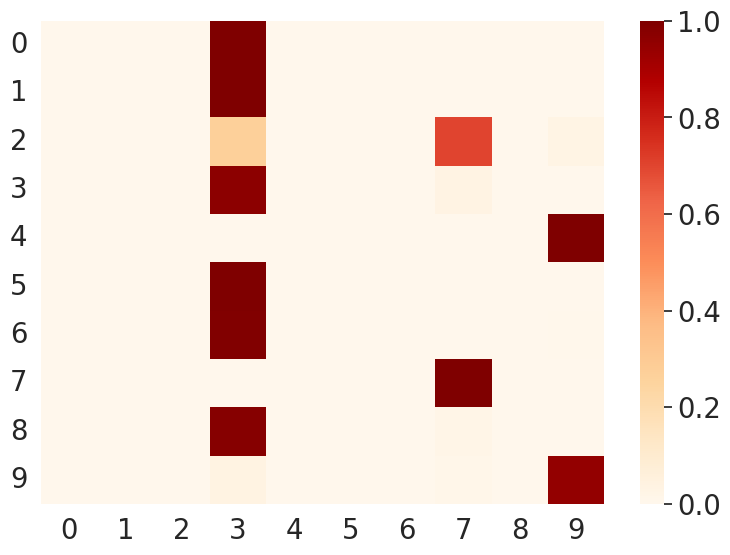

Doing 128 ...
TO ADD 
Loading ../shortcut_mitigation/outputs++/mnadd-even-odd/baseline/ccn+/supervisions-via-augmentations-1.0/ccn+_128.pth...


100%|██████████| 120/120 [01:09<00:00,  1.73it/s]


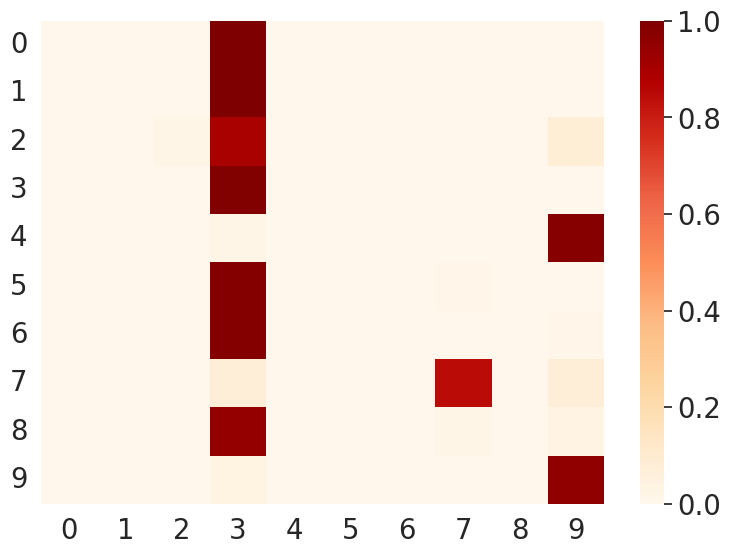

Results saved in  ../shortcut_mitigation/outputs++/mnadd-even-odd/baseline/ccn+/supervisions-via-augmentations-1.0/ccn+_results.txt


/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
# Get loaders
if args.dataset == 'boia_original':
    _, _, test_loader = dataset.get_data_loaders(batch_size=16)
elif args.dataset == 'boia_original_embedded':
    _, _, test_loader = dataset.get_data_loaders(args)
else:
    _, _, test_loader = dataset.get_data_loaders()
    
# Get ood set if it exists
ood_loader = getattr(dataset, "ood_loader_ambulance", None)
# ood_ambulance = getattr(dataset, "ood_loader_2", None) # getattr(dataset, "ood_loader_ambulance", None)
use_concept_extractor = False

# ! new for prototypes
support_images, support_labels, concept_extractor = None, None, None
if args.prototypes and args.task == 'addition':        
    tr_dataloader = torch.load('data/prototypes/proto_loader_dataset.pth')
    result = get_augmented_support_query_set(tr_dataloader, no_augmentations=NA, debug=False)
    support_images, support_labels, query_images, query_labels, no_aug = result
    if NA:
        support_images = torch.cat([support_images, query_images], dim=0)
        support_labels = torch.cat([support_labels, query_labels], dim=0)
        assert support_images.size() == torch.Size([20, 1, 28, 28]), f"support_images_aug size is {support_images.size()}, expected [20, 1, 28, 28]"
        assert support_labels.size() == torch.Size([20, 1]), f"support_labels_aug size is {support_labels.size()}, expected [20, 1]"
    use_concept_extractor = False
    
    if args.hide:
        # Create a boolean mask using torch.isin (available in recent versions of PyTorch)
        mask = ~torch.isin(support_labels, torch.tensor(args.hide))
        # Use tensor indexing to filter both images and labels
        support_images = support_images[mask]
        support_labels = support_labels[mask]

        # Ensure the channel dimension is preserved
        if support_images.dim() == 3:  # If shape is [batch_filtered, 28, 28]
            support_images = support_images.unsqueeze(1)  # Add back the channel dim to get [batch_filtered, 1, 28, 28]
        if support_labels.dim() == 1:  # If shape is [batch_filtered]
            support_labels = support_labels.unsqueeze(1)  # Add back the channel dim to get [batch_filtered, 1]

elif args.prototypes and args.task == 'patterns':
    support_images = torch.load('data/kand_annotations/pnet_proto/concept_prototypes.pt')
    support_labels = torch.load('data/kand_annotations/pnet_proto/labels_prototypes.pt')
    if NA:
        print("Excluding Augmentations...")
        pairs = {(s, c): (support_labels[:, 0] == s) & (support_labels[:, 1] == c)
                for s in range(3) for c in range(3)}
        pair_indices = {k: v.nonzero(as_tuple=True)[0].tolist() for k, v in pairs.items()}
        selected_indices = []
        for s in range(3):
            for c in range(3):
                idxs = pair_indices[(s, c)]
                assert len(idxs) > 0, f"No samples found for pair ({s},{c})"
                chosen = random.choice(idxs)
                selected_indices.append(chosen)
        support_images = support_images[selected_indices]
        support_labels = support_labels[selected_indices]
        print("Selected indices:", selected_indices)
        print("Sampled labels:\n", support_labels)
        print(support_images.shape)
        print(support_labels.shape)
    use_concept_extractor = True
    my_yolo_project_path = f"ultralytics-{args.GPU_ID}/"
    args.yolo_folder = my_yolo_project_path
    
elif args.model in ['kanddplsinglejoint', 'kanddplsingledisj',
                    'kandltnsinglejoint', 'kandltnsingledisj',
                    'kandslsinglejoint', 'kandslsingledisj']:
    use_concept_extractor = True
    my_yolo_project_path = f"ultralytics-{args.GPU_ID}/"
    args.yolo_folder = my_yolo_project_path


# Evaluate
evaluate(
    model,
    test_loader,
    args.dataset,
    model_name=args.model,
    support_images=support_images,
    support_labels=support_labels,
    use_concept_extractor=use_concept_extractor,
    resize_transform=T.Resize((64, 64)),
    args=args,
    ood_set=ood_loader,
    total_classes=np.unique(support_labels).size,
    ood_set_2=None,
)